In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=84fc3f7e1a52f440568f0e437013b3e729944c6a076bcfa1c3654d97739f9491
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
spark = SparkSession.builder.getOrCreate()
spark_context = spark.sparkContext
sqlContext = SQLContext(spark_context)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
%%bash

# Download the data files from github
# If the data file does not exist in the colab environment
data_file=titanic_original.csv
if [[ ! -f ${data_file} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file} 
fi

--2022-10-06 22:58:01--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/titanic_original.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106975 (104K) [text/plain]
Saving to: ‘titanic_original.csv’

     0K .......... .......... .......... .......... .......... 47% 1.69M 0s
    50K .......... .......... .......... .......... .......... 95% 2.48M 0s
   100K ....                                                  100% 48.3M=0.05s

2022-10-06 22:58:02 (2.10 MB/s) - ‘titanic_original.csv’ saved [106975/106975]



In [ ]:
titanic_df = spark.read.csv('titanic_original.csv', header=True, inferSchema=True)

[Column Descriptions](https://data.world/nrippner/titanic-disaster-dataset): <br>
survival - Survival (0 = No; 1 = Yes) <br>
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd) <br>
name - Name <br>
sex - Sex <br>
age - Age <br>
sibsp - Number of Siblings/Spouses Aboard <br>
parch - Number of Parents/Children Aboard <br>
ticket - Ticket Number <br>
fare - Passenger Fare <br>
cabin - Cabin <br>
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) <br>
boat - Lifeboat (if survived) <br>
body - Body number (if did not survive and body was recovered) <br>

In [ ]:
titanic_df_pd = titanic_df.limit(10).toPandas()
display(titanic_df_pd.head())
display("types:", titanic_df_pd.dtypes)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


'types:'

pclass         int32
survived       int32
name          object
sex           object
age          float64
sibsp          int32
parch          int32
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [ ]:
# some basic cleanup
drop_cols = ['boat', 'body']
new_titanic_df = titanic_df.\
    drop(*drop_cols).\
    withColumnRenamed('home.dest', 'home_dest') .\
    dropna(subset=['pclass', 'age', 'sibsp', 'parch', 'fare', 'survived'])

In [ ]:
from pyspark.sql.functions import isnan, isnull, when, count, col

new_titanic_df.select([count(when(isnull(c), c)).alias(c) for c in new_titanic_df.columns]).show()
new_titanic_df.select([count(when(isnan(c), c)).alias(c) for c in new_titanic_df.columns]).show()

+------+--------+----+---+---+-----+-----+------+----+-----+--------+---------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|home_dest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+---------+
|     0|       0|   0|  0|  0|    0|    0|     0|   0|  773|       2|      360|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+---------+

+------+--------+----+---+---+-----+-----+------+----+-----+--------+---------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|home_dest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+---------+
|     0|       0|   0|  0|  0|    0|    0|     0|   0|    0|       0|        0|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+---------+



In [ ]:
training, test = new_titanic_df.randomSplit([0.8, 0.2], 0)
training.show(5)

+------+--------+--------------------+------+----+-----+-----+--------+------+-------+--------+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|  fare|  cabin|embarked|           home_dest|
+------+--------+--------------------+------+----+-----+-----+--------+------+-------+--------+--------------------+
|     1|       0|"Lindeberg-Lind, ...|  male|42.0|    0|    0|   17475| 26.55|   null|       S|   Stockholm, Sweden|
|     1|       0|"Rosenshine, Mr. ...|  male|46.0|    0|    0|PC 17585|  79.2|   null|       C|        New York, NY|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|  113781|151.55|C22 C26|       S|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|  113781|151.55|C22 C26|       S|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|25.0|    1|    2|  113781|151.55|C22 C26|       S|Montreal, PQ / Ch...|
+------+--------+--------------------+------+----+-----+-----+--

## classic pipeline

Create a logistic regression pipeline

In [ ]:
model0 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'],
                                        outputCol='features'),
                  classification.LogisticRegression(labelCol='survived', featuresCol='features')])

Fit the logistic regression model on the training data

In [ ]:
model0_fitted = model0.fit(training)

Use the fitted logistic regression model to make predictions on the test data.  Note that the logistic regression model adds `rawPrediction`, `probability`, and `prediction` cols to the dataframe.  `rawPrediction` is the direct probability calculation.  `probability` is `class_k probability: 1/(1 + exp(-rawPrediction_k))`.  The probability col is the predicted probability of a 0 or 1 respectively.  See this [stack overflow](https://stackoverflow.com/questions/37903288/what-do-columns-rawprediction-and-probability-of-dataframe-mean-in-spark-mll) post for more information on the added columns.

In [ ]:
model0_fitted.transform(test).toPandas().head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home_dest,features,rawPrediction,probability,prediction
0,1,0,"Cavendish, Mr. Tyrell William",male,36.0,1,0,19877,78.8500,C46,S,"Little Onn Hall, Staffs","[1.0, 36.0, 1.0, 0.0, 78.85]","[-0.37011446658624303, 0.37011446658624303]","[0.4085133626940247, 0.5914866373059753]",1.0
1,1,0,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S,"Amenia, ND","[1.0, 46.0, 1.0, 0.0, 61.175]","[0.07084806676687272, -0.07084806676687272]","[0.5177046116955324, 0.4822953883044676]",0.0
2,1,0,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.4250,C86,C,"Deephaven, MN / Cedar Rapids, IA","[1.0, 50.0, 1.0, 0.0, 106.425]","[0.04922892489907671, -0.04922892489907671]","[0.5123047462923664, 0.48769525370763356]",0.0
3,1,0,"Dulles, Mr. William Crothers",male,39.0,0,0,PC 17580,29.7000,A18,C,"Philadelphia, PA","[1.0, 39.0, 0.0, 0.0, 29.7]","[-0.36282858731093803, 0.36282858731093803]","[0.41027501758223733, 0.5897249824177626]",1.0
4,1,0,"Evans, Miss. Edith Corse",female,36.0,0,0,PC 17531,31.6792,A29,C,"New York, NY","[1.0, 36.0, 0.0, 0.0, 31.6792]","[-0.48254037466767175, 0.48254037466767175]","[0.38165243245079256, 0.6183475675492074]",1.0


The cell below calculates the predicted percent survived

In [ ]:
model0_fitted.transform(test).select(fn.avg(fn.expr('prediction = survived').cast('float'))).show()

+-------------------------------------------+
|avg(CAST((prediction = survived) AS FLOAT))|
+-------------------------------------------+
|                         0.6846846846846847|
+-------------------------------------------+



The cell below calculates the percent survived in the original dataframe

In [ ]:
new_titanic_df.select(fn.avg('survived')).show()

+-------------------+
|      avg(survived)|
+-------------------+
|0.40861244019138754|
+-------------------+



Another way of evaluating the model performance is with the `BinaryClassificationEvaluator`.  The [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html) calculates the area under the receiver operating characteristic curve (ROC curve) by default.  `BinaryClassificationEvaluator` uses `rawPrediction` and `label` cols as default column names for the area under the curve (AUC) calculation.  The cell below overrides the label col name with `survived`.

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='survived')

In [ ]:
evaluator.evaluate(model0_fitted.transform(test))

0.7327861952861949

If we wanted to modify the pipeline to add "sex" (gender) as a feature, we need to modify the point of entry and the next transformation.  The StringIndexer converts labels where the label with the highest count is label 0, next highest is label 1, etc.  See the spark documentation for [StringIndexer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexerModel.html) for more information.

In [ ]:
model1 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'], 
                                                  outputCol='features'),
                          feature.StringIndexer(inputCol='sex', outputCol='encoded_sex'),
                          feature.VectorAssembler(inputCols=['features', 'encoded_sex'], outputCol='final_features'),
                 classification.LogisticRegression(labelCol='survived', featuresCol='final_features')])

In [ ]:
model1_fitted = model1.fit(training)

In [ ]:
evaluator.evaluate(model1_fitted.transform(test))

0.8341750841750837

The [StringIndexerModel](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexerModel.html) _from_labels_ method can be used to control the order when encoding ordinal data.  There really isn't any ordinal data in the Titanic data so in the cell below we create a data frame of T-Shirt sizes and then use the StringIndexerModel to encode the data and retain the relative sizing.

In [ ]:
# create a data frame with T-Shirt sizes
from pyspark.sql.types import StringType
sizes_df = spark.createDataFrame(['small', 'medium', 'large', 'extra_large', 'small', 'medium', 'extra_large'], 
                                 StringType()).withColumnRenamed('value', 'sizes')
sizes_df.show()

ordinal_encoder_pipe = Pipeline(stages=[feature.StringIndexerModel.from_labels(['small', 'medium', 'large', 'extra_large'], 
                                                                              inputCol="sizes", outputCol='ordinal_values')])
ordinal_encoder_pipe.fit(sizes_df).transform(sizes_df).show()

+-----------+
|      sizes|
+-----------+
|      small|
|     medium|
|      large|
|extra_large|
|      small|
|     medium|
|extra_large|
+-----------+

+-----------+--------------+
|      sizes|ordinal_values|
+-----------+--------------+
|      small|           0.0|
|     medium|           1.0|
|      large|           2.0|
|extra_large|           3.0|
|      small|           0.0|
|     medium|           1.0|
|extra_large|           3.0|
+-----------+--------------+



# Automated evaluator

In [ ]:
# Execute the classification pipeline defined by model_fitted using data as the input data.  Returns ROC AUC.
# Uses model_pipeline to obtain information needed to execute the fitted model.
# Args
# model_pipeline:  The unfitted pipeline definition.
# model_fitted: The fitted pipeline
# data: The data on which to perform predictions
def binary_evaluation(model_pipeline, model_fitted, data):
    return BinaryClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(), 
                                         rawPredictionCol=model_pipeline.getStages()[-1].getRawPredictionCol()).\
                                         evaluate(model_fitted.transform(data))

# Initial model

$$
p(survived = 1) = f(\text{pclass}, \text{age}, \text{sibsp}, \text{parch}, \text{fare})
$$

In [ ]:
model1_pipeline = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'], 
                                                           outputCol='features'),
                           classification.LogisticRegression(labelCol='survived')])

In [ ]:
model1_fitted = model1_pipeline.fit(training)

In [ ]:
binary_evaluation(model1_pipeline, model1_fitted, test)

0.7327861952861949

In [ ]:
model1_fitted.stages

[VectorAssembler_bddabffc8f5b,
 LogisticRegressionModel: uid=LogisticRegression_1b4d74b97db0, numClasses=2, numFeatures=5]

In [ ]:
model1_fitted.stages[-1].coefficients

DenseVector([-0.9506, -0.0374, -0.2909, 0.3312, 0.0038])

In [ ]:
dir(model1_fitted.stages[-1].summary)

How to extract training precision recall data from the model

In [ ]:
pr_data=model1_fitted.stages[-1].summary.pr.toPandas()
pr_data.head()

,recall,precision
0,0.000000,1.000000
1,0.002967,1.000000
2,0.005935,1.000000
3,0.005935,0.666667
4,0.008902,0.750000


In [ ]:
# extract TPR and FPR values from the model
fpr = model1_fitted.stages[-1].summary.roc.select('FPR').toPandas()
tpr = model1_fitted.stages[-1].summary.roc.select('TPR').toPandas()
print(fpr.head())
print(tpr.head())

        FPR
0  0.000000
1  0.000000
2  0.000000
3  0.002058
4  0.002058
        TPR
0  0.000000
1  0.002967
2  0.005935
3  0.005935
4  0.008902


In [ ]:
model1_fitted.stages[-1].intercept

2.6599312218734923

# Some preprocessing of the data

Text(0.5, 1.01, 'Titanic Data Pair Plot')

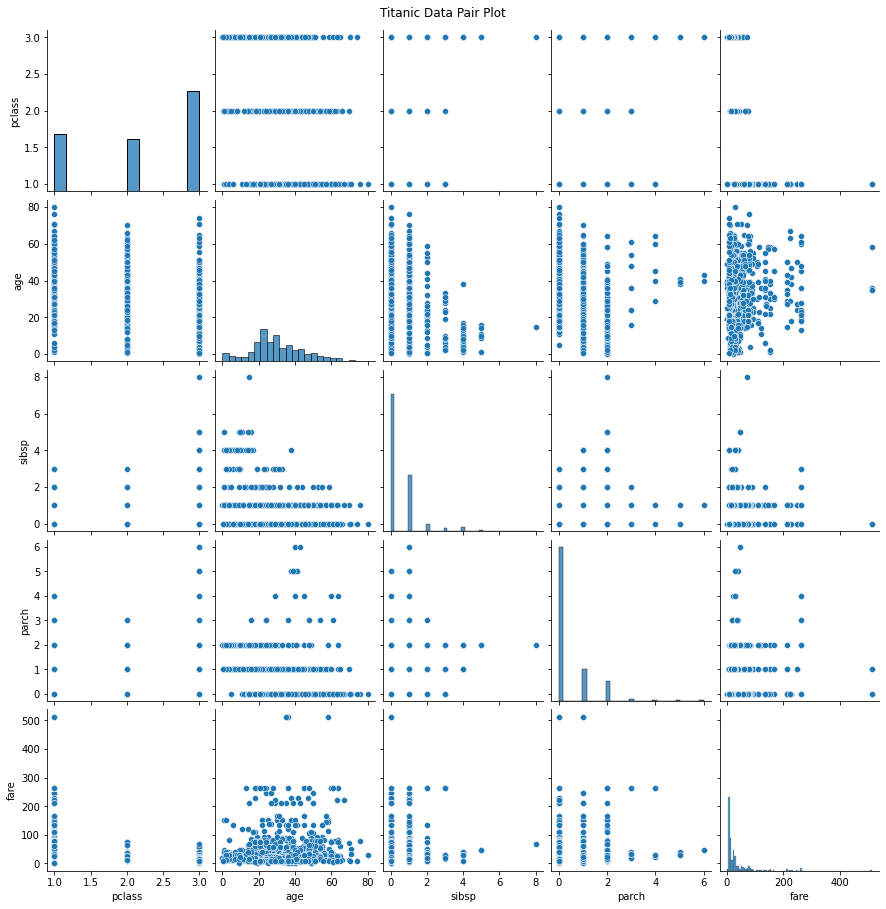

In [ ]:
ax = sns.pairplot(new_titanic_df.toPandas()[['pclass', 'age', 'sibsp', 'parch', 'fare']])
ax.fig.suptitle("Titanic Data Pair Plot", y=1.01)

In [ ]:
import numpy as np

The following cell is a quick demo of the [StandardScaler](https://spark.apache.org/docs/latest/ml-features#standardscaler).

---



In [ ]:
# create a vector assembler
va = feature.VectorAssembler(inputCols=["fare"], outputCol="fare_vec")

# create a temp data frame for this demo
tmpdf = va.transform(new_titanic_df)

# create a standard scaler which sacles mean and std
sScaler = feature.StandardScaler(withMean=True, withStd=True, inputCol="fare_vec", outputCol="scaled_fare")

# fit and transform the standard scaler, and show the results
sScaler.fit(tmpdf).transform(tmpdf).select(['fare', 'fare_vec', 'scaled_fare']).show(5)

+--------+----------+-------------------+
|    fare|  fare_vec|        scaled_fare|
+--------+----------+-------------------+
|211.3375|[211.3375]|[3.133742712618657]|
|  151.55|  [151.55]|[2.060985086378592]|
|  151.55|  [151.55]|[2.060985086378592]|
|  151.55|  [151.55]|[2.060985086378592]|
|  151.55|  [151.55]|[2.060985086378592]|
+--------+----------+-------------------+
only showing top 5 rows



The following cell applies a standard scaler function to 5 columns of the titanic data.  Notice how the scale changed between the below and above pair plots.  Standardization is the process of subtracting the mean and dividing by the standard deviation for each column. Standardization is similar to transforming all columns in the data set to be on the same scale.

Text(0.5, 1.03, 'Titanic Data Pair Plot Using Standard Scaler\nCompare X axis with Above Pairplot')

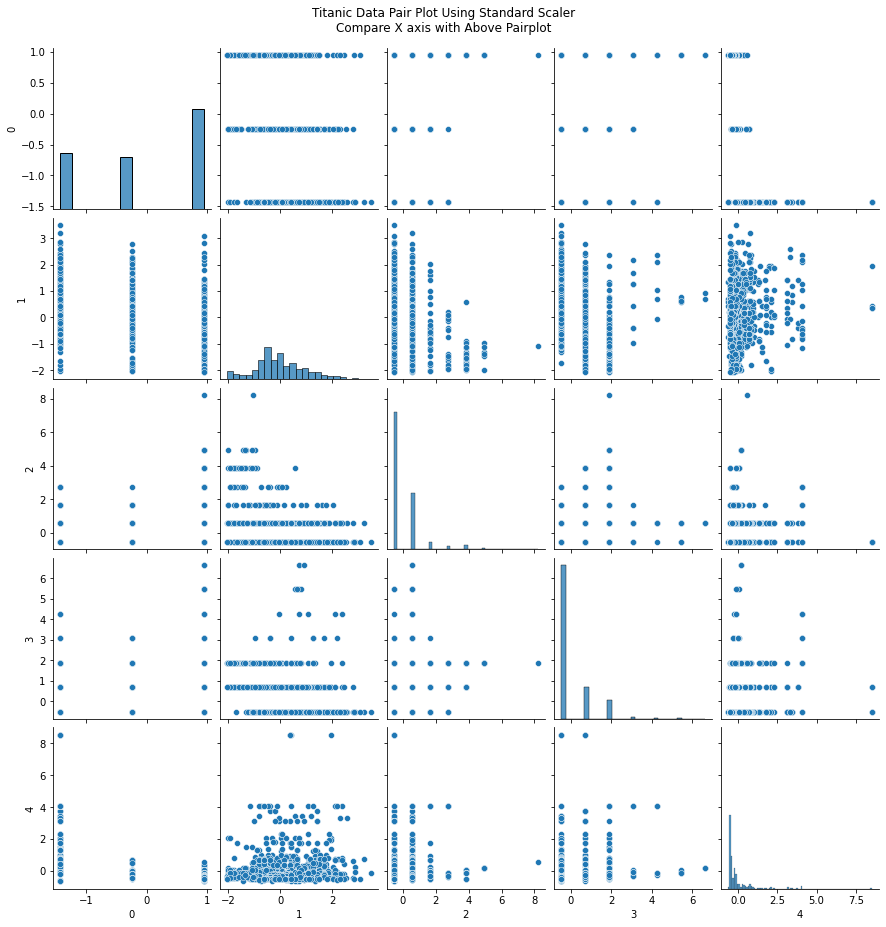

In [ ]:
pairplot_va = feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'], outputCol='features')
pairplot_lr = classification.LogisticRegression(labelCol='survived')
pairplot_sc = feature.StandardScaler(withMean=True, inputCol='features')
pairplot_pipe = Pipeline(stages=[pairplot_va, pairplot_lr, pairplot_sc])
fitted_pairplot_pipe = pairplot_pipe.fit(new_titanic_df)
scaled_df = fitted_pairplot_pipe.transform(new_titanic_df)
pd_scaled_df = scaled_df.toPandas()
stacked_array = np.vstack(pd_scaled_df.iloc[:,-1])
pairplot_df = pd.DataFrame(stacked_array)
ax = sns.pairplot(pairplot_df)
ax.fig.suptitle("Titanic Data Pair Plot Using Standard Scaler\nCompare X axis with Above Pairplot", y=1.03)

Text(0.5, 1.0, 'Age Histogram\nUnscaled Data')

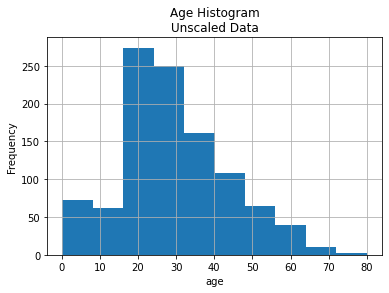

In [ ]:
ax = new_titanic_df.toPandas().age.hist()
ax.set_xlabel('age')
ax.set_ylabel('Frequency')
ax.set_title("Age Histogram\nUnscaled Data")

The following cell contains the same code as the cell above that produced the pairplot except that it also shows the output of various stages of the processing to demonstrate what the pipe is doing.  The goal of this cell is to produce a histogram of the standardized age data for comparison to the age histogram above.

Text(0.5, 1.0, 'Titanic Age Histogram\nAge Scaled with Standard Scaler')

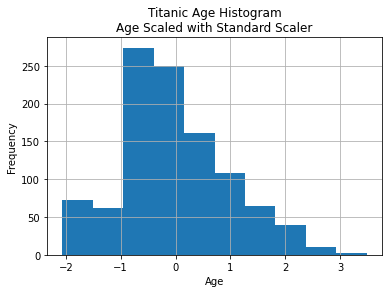

In [ ]:
pairplot_df.columns = ['pclass', 'age', 'sibsp', 'parch', 'fare']
ax = pairplot_df.age.hist()
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")
ax.set_title("Titanic Age Histogram\nAge Scaled with Standard Scaler")

## Initial model on standardized results

One common use of standardization is to make the loss function converge faster.  In some cases, the loss function will not converge if the input data is not standardized in some way (like neural networks).  Logistic regression does not require standardized data to make the loss function converge.  Another use for scaling features in linear regression is that it allows us to compare model coefficients.  See the spark documentation on [StandardScaler](https://spark.apache.org/docs/latest/ml-features.html#standardscaler) for more information.<br><br>
The difference between model1_pipeline and model2_pipeline is that model2_pipeline uses the standard scaler and model1_pipeline does not use the standard scaler.  Note that model1_pipeline and model2_pipeline produce the exact same test results.

In [ ]:
va = feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'], outputCol='features')
sc = feature.StandardScaler(withMean=True, inputCol='features')
lr = classification.LogisticRegression(labelCol='survived')
model2_pipeline = Pipeline(stages=[va, sc, lr])

In [ ]:
model2_fitted = model2_pipeline.fit(training)

In [ ]:
binary_evaluation(model1_pipeline, model1_fitted, test)

0.7327861952861949

In [ ]:
binary_evaluation(model2_pipeline, model2_fitted, test)

0.7327861952861949

In [ ]:
model2_fitted.stages[-1].intercept

2.6599312218734923

In [ ]:
print(model2_fitted.stages[-1].coefficients)
print(type(model2_fitted.stages[-1].coefficients))
print(model2_fitted.stages[-1].coefficients.toArray())
print(type(model2_fitted.stages[-1].coefficients.toArray()))

[-0.9506217827471747,-0.0374071794757553,-0.2909430029693237,0.33122909403825396,0.003784483088857828]
<class 'pyspark.ml.linalg.DenseVector'>
[-0.95062178 -0.03740718 -0.290943    0.33122909  0.00378448]
<class 'numpy.ndarray'>


## other scaling

The following cell uses the `MaxAbsScaler` to scale the data between -1 and +1.  `MaxAbsScaler` does not center the data by subtracting the mean.  See the spark documentation on [MaxAbsScaler](https://spark.apache.org/docs/latest/ml-features.html#maxabsscaler) for more information.

Text(0.5, 1.0, 'Age Histogram\nAge Transformed with Max Abs Scaler')

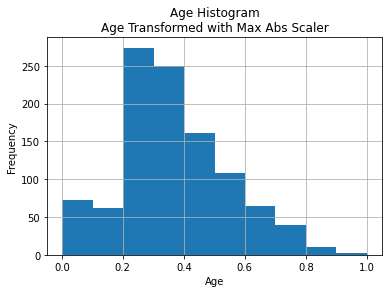

In [ ]:
va = feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'], outputCol='features')
max_abs_scaler = feature.MaxAbsScaler(inputCol='features')
pipeline = Pipeline(stages=[va, max_abs_scaler])
fitted_pipe = pipeline.fit(new_titanic_df)
transformed_df = fitted_pipe.transform(new_titanic_df)
pd_transformed_df = transformed_df.toPandas()
pd_transformed_df = pd.DataFrame(np.vstack(pd_transformed_df.iloc[:, -1]))
pd_transformed_df.columns = ['pclass', 'age', 'sibsp', 'parch', 'fare']
ax = pd_transformed_df.age.hist()
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title("Age Histogram\nAge Transformed with Max Abs Scaler")

Text(0.5, 1.0, 'Age Histogram\nUnscaled Age Data')

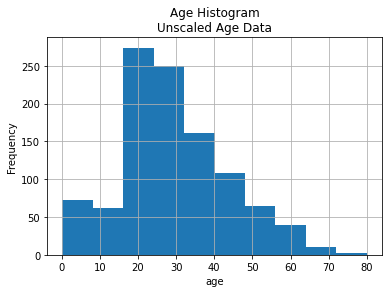

In [ ]:
ax = new_titanic_df.toPandas().age.hist()
ax.set_xlabel('age')
ax.set_ylabel('Frequency')
ax.set_title("Age Histogram\nUnscaled Age Data")

# Bucketizer

The Bucketizer transforms a col of continuous data into discrete buckets via user specified splits.  See the spark documentation for the [Bucketizer](https://spark.apache.org/docs/latest/ml-features.html#bucketizer) for more information. 

Text(0, 0.5, 'Frequency')

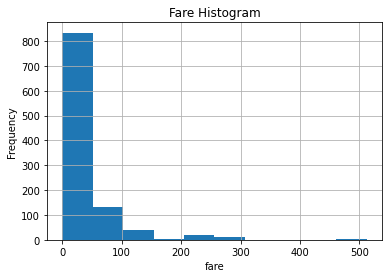

In [ ]:
new_titanic_df.toPandas().fare.hist()
plt.title('Fare Histogram')
plt.xlabel('fare')
plt.ylabel('Frequency')

The plot below shows a histogram of the fare transformed into 5 buckets.

Text(0, 0.5, 'Frequency')

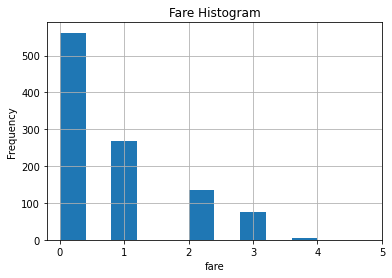

In [ ]:
feature.Bucketizer(splits=[0, 20, 50, 100, 400, 800], inputCol='fare').transform(new_titanic_df).toPandas().iloc[:, -1].hist()
plt.xticks([0, 1, 2, 3, 4, 5]);
plt.title('Fare Histogram')
plt.xlabel('fare')
plt.ylabel('Frequency')

The QuantileDiscretizer takes col with continuous data and transforms it into binned categorical features where the number of bins is defined by the user.  See the spark documentation for [QuantileDiscretizer](https://spark.apache.org/docs/latest/ml-features.html#quantilediscretizer) for more information.

In [ ]:
qd = feature.QuantileDiscretizer(numBuckets=4, inputCol='fare', outputCol='fare_bins').fit(new_titanic_df)

In [ ]:
qd.getSplits()

[-inf, 8.05, 15.75, 35.5, inf]

Text(0, 0.5, 'Frequency')

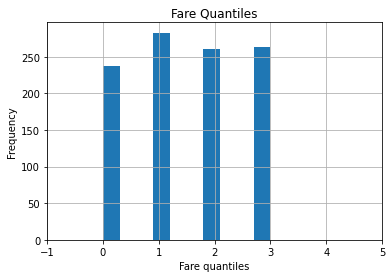

In [ ]:
feature.QuantileDiscretizer(numBuckets=4, inputCol='fare', outputCol='fare_bins').fit(new_titanic_df).transform(new_titanic_df).toPandas().iloc[:, -1].hist()
plt.xticks([-1, 0, 1, 2, 3, 4, 5]);
plt.title('Fare Quantiles')
plt.xlabel('Fare quantiles')
plt.ylabel('Frequency')

In [ ]:
# full model

Define a `gender_pipe` that uses the StringIndexer to encode the gender data.  The StringIndexer was used and described earlier in this notebook.

In [ ]:
gender_pipe = feature.StringIndexer(inputCol='sex', handleInvalid='skip',outputCol="genderIndex")

In [ ]:
titles_list = " Capt  Col  Don  Dona  Dr  Jonkheer  Lady  Major  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  Rev  Sir".lower().split()

Create a title pipeline that creates a vector of counts for each title using the CountVectorizer.  The CountVectorizer produces a count of each word in the titles_list.  See the spark documentation for [RegexTokenizer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.RegexTokenizer.html) and [CountVectorizer](https://spark.apache.org/docs/latest/ml-features.html#countvectorizer) for more information.  Setting gaps to False specifies continuous expression matching.  The '\\b' is a word boundary.  The expression below essentially creates a regular expression that matches the logical OR of any of the titles in the titles_list.  Here is a link to information to [Java Regular Expressions](https://docs.oracle.com/javase/8/docs/api/java/util/regex/Pattern.html).  Search for \\\b for an explanation about why the double back slash is needed.

In [ ]:
title_pipe = Pipeline(stages=[feature.RegexTokenizer(pattern="\\b(" + "|".join(titles_list) + ")\\b", gaps=False,
                                                     inputCol='name',outputCol = 'tokens'),
                      feature.CountVectorizer(inputCol="tokens", outputCol="count")])

Show the distinct embarkment codes in the data.

In [ ]:

.select('embarked').distinct().show()

+--------+
|embarked|
+--------+
|       Q|
|    null|
|       C|
|       S|
+--------+



The OneHotEncoder encodes a categorical value into a vector of Boolean values where the Boolean is true in the position corresponding to the feature.  The length of the one hot vector is equal to the number of distinct feature values - 1.  For example, if we have categorical values 'Q', 'C', 'S', and 'O', this will be transformed into a one hot vector of length 3 because there are 4 distinct feature values.  Assuming the ordering in the code example below, if the value is 'Q', the one hot vector will be 001.  If the value is 'C', the one hot vector will be 010.  If the value is 'S', the one hot vector will be 100.  If the value is 'O', the one hot vector will be 000.  Essentially, a 1 appears in the position corresponding to the value, and 0 everywhere else.  <br>

Value One Hot Vector <br>
Q &emsp;&nbsp;&nbsp; 001<br>
C &emsp;&nbsp;&nbsp; 010 <br>
S &emsp;&nbsp;&nbsp; 100 <br>
O &emsp;&nbsp;&nbsp; 000 <br>

The interpretation of the OneHotEncoder values in the output below is as follows (taken from this [stackoverflow](https://stackoverflow.com/questions/42295001/how-to-interpret-results-of-spark-onehotencoder) post:  The values in column categoryVec are represented in sparse format. In this format the zeros of a vector are not printed. The first value (3) shows the length of the vector, the second value is an array that lists zero or more indices where non-zero entries are found. The third value is another array that tells which numbers are found at these indices. So (3,[2],[1.0]) means a vector of length 3 with 1.0 at position 2 and 0 elsewhere. <br>

See the spark documentation for [OneHotEncoder](https://spark.apache.org/docs/latest/ml-features.html#onehotencoder-deprecated-since-230) for more information.

In [ ]:
embarked_pipe = Pipeline(stages=[feature.StringIndexer(inputCol='embarked', handleInvalid='skip',outputCol = "indexed"), 
                                 feature.OneHotEncoder(inputCol='indexed',outputCol = "One Hot Embarked")])

In [ ]:
embarked_pipe.fit(new_titanic_df.select('embarked')).transform(new_titanic_df.select('embarked')).distinct().show()

+--------+-------+----------------+
|embarked|indexed|One Hot Embarked|
+--------+-------+----------------+
|       S|    0.0|   (2,[0],[1.0])|
|       Q|    2.0|       (2,[],[])|
|       C|    1.0|   (2,[1],[1.0])|
+--------+-------+----------------+



Create a cabin pipeline that one hot encodes the `cabin_col`

In [ ]:
cabin_pipe = Pipeline(stages=[feature.SQLTransformer(statement='select *, substring(cabin,1,1) as cabin_col from __THIS__'),
                              feature.StringIndexer(inputCol='cabin_col', outputCol='cabin_col2', handleInvalid='skip'),
                              feature.OneHotEncoder(inputCol='cabin_col2',outputCol = "One Hot Cabin")])

Create a pipeline to apply a standard scaler to the numeric columns in the data.

In [ ]:
numerical_features = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch'], 
                                                              outputCol = 'num_features'),
                                      feature.StandardScaler(inputCol="num_features", outputCol="scaledFeatures")])

Create an `all_features` pipeline that collects all the pipelines together into one pipeline.

In [ ]:
all_features = Pipeline(stages=[numerical_features,
                               feature.QuantileDiscretizer(inputCol='fare', outputCol='fare_bins', numBuckets=4),
                               gender_pipe,title_pipe,embarked_pipe,cabin_pipe,
                               feature.VectorAssembler(inputCols=['scaledFeatures','fare_bins','genderIndex','count',
                                                                'One Hot Embarked','One Hot Cabin'],outputCol = 'features')
                               ])

In [ ]:
lr = classification.LogisticRegression(labelCol='survived')

In [ ]:
final_model_pipeline = Pipeline(stages=[all_features, lr])

Define a grid search [ParamGridBuilder](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html) object.  The grid search object iterates over different combinations of paramters (elasticNetParam and regParam in this example).  

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .build()

The length of the grid is 12 because it implements all combinations of elasticNetParam (3 options) and regParam (4 options).  

In [ ]:
len(paramGrid)

12

Define an evaluator and a `CrossValidator`.  The [CrossValidator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator) performs cross validation on each model in the grid defined above.  The evaluator is used to evaluate the performance of each pass of the cross validation.

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)

The cell below will take a while to complete because we are training and testing 12 separate logistic regression models.  And for each model, we train and evaluate the model twice (numFolds = 2).  The total number of training and evaluation cycles is 12 * 2 = 24.

In [ ]:
final_model_fitted = crossval.fit(training)

In [ ]:
final_model_fitted.avgMetrics

[0.8472220961498504,
 0.8505395645359425,
 0.8443953014339972,
 0.8433680637502594,
 0.8466416589510373,
 0.8500975548011382,
 0.8443953014339972,
 0.844033473727526,
 0.842301743631328,
 0.8493471720454181,
 0.8443953014339972,
 0.8443103286555438]

Show the test data and then test and predict on the test data.

In [ ]:
test.show()

+------+--------+--------------------+------+----+-----+-----+-----------+--------+-------+--------+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|     ticket|    fare|  cabin|embarked|           home_dest|
+------+--------+--------------------+------+----+-----+-----+-----------+--------+-------+--------+--------------------+
|     1|       0|Cavendish, Mr. Ty...|  male|36.0|    1|    0|      19877|   78.85|    C46|       S|Little Onn Hall, ...|
|     1|       0|Chaffee, Mr. Herb...|  male|46.0|    1|    0|W.E.P. 5734|  61.175|    E31|       S|          Amenia, ND|
|     1|       0|Douglas, Mr. Walt...|  male|50.0|    1|    0|   PC 17761| 106.425|    C86|       C|Deephaven, MN / C...|
|     1|       0|Dulles, Mr. Willi...|  male|39.0|    0|    0|   PC 17580|    29.7|    A18|       C|    Philadelphia, PA|
|     1|       0|Evans, Miss. Edit...|female|36.0|    0|    0|   PC 17531| 31.6792|    A29|       C|        New York, NY|
|     1|       0|  Gigli

Print the AUC accuracy of the test data on the best model produced by the grid search.

In [ ]:
evaluator.evaluate(final_model_fitted.transform(test))

0.8090225563909775

Print the stages of the best model produced from the grid search.

In [ ]:
final_model_fitted.bestModel.stages

[PipelineModel_c3dbaba92da5,
 LogisticRegressionModel: uid=LogisticRegression_ac43381d0322, numClasses=2, numFeatures=31]

Print the stages of the pipeline in the above list of stages

In [ ]:
final_model_fitted.bestModel.stages[0].stages

[PipelineModel_4a8e8fef6fcc,
 Bucketizer_3a396e54833e,
 StringIndexerModel: uid=StringIndexer_26d24b90a71f, handleInvalid=skip,
 PipelineModel_f5622760ef04,
 PipelineModel_c698a93ba908,
 PipelineModel_14c7167f7490,
 VectorAssembler_c6f872ee257a]

Get a handle to the bucketizer in the first stage of the best model.

In [ ]:
b = final_model_fitted.bestModel.stages[0].stages[1]

In [ ]:
b.getInputCol()

'fare'

In [ ]:
b.getSplits()

[-inf, 8.05, 15.55, 35.5, inf]

Access and show info about the logistic regression model (last element of the pipeline).

In [ ]:
final_model_fitted.bestModel.stages[-1]

LogisticRegressionModel: uid=LogisticRegression_ac43381d0322, numClasses=2, numFeatures=31

In [ ]:
final_model_fitted.bestModel.stages[-1].coefficients

DenseVector([0.0403, -0.3201, 0.3336, -0.2863, 0.1433, 1.3195, -1.6386, 0.5792, 0.9072, 2.2382, 0.0, 2.3072, -0.4173, -0.2581, 1.072, 1.7278, 2.848, 0.0, 0.0, -3.5936, 1.114, 0.0, -0.4428, 0.2936, -0.3961, 0.3321, 0.9884, -0.0546, 0.4239, 0.7986, -3.5485])

In [ ]:
len(final_model_fitted.bestModel.stages[-1].coefficients)

31

In [ ]:
lr_fit = final_model_fitted.bestModel.stages[-1]

In [ ]:
lr_fit.summary.featuresCol

'features'

Access the numerical_features pipeline and print it's input cols.

In [ ]:
final_model_fitted.bestModel.stages[0].stages[0].stages[0].getInputCols()

['pclass', 'age', 'sibsp', 'parch']

Show the stages within this stage of the pipeline.  Remember that the final pipeline is made up of sub pipelines.  Here we are accessing the numerocal_features stage which contains the vector assembler and standard scaler.

In [ ]:
final_model_fitted.bestModel.stages[0].stages[0].stages

[VectorAssembler_1aba4a62b7e9,
 StandardScalerModel: uid=StandardScaler_d8f8b05d6428, numFeatures=4, withMean=false, withStd=true]

Access the QuantileDiscreteizer element of the pipeline and print it's input col.

In [ ]:
final_model_fitted.bestModel.stages[0].stages[1]

Bucketizer_3a396e54833e

In [ ]:
final_model_fitted.bestModel.stages[0].stages[1].getInputCol()

'fare'

Access the gender_pipe and print the labels.

In [ ]:
si = final_model_fitted.bestModel.stages[0].stages[2]

In [ ]:
si.labels

['male', 'female']

Access the title_pipe and print it's vocabulary.

In [ ]:
final_model_fitted.bestModel.stages[0].stages[3].stages[1].vocabulary

['mr',
 'miss',
 'mrs',
 'master',
 'rev',
 'dr',
 'col',
 'major',
 'mlle',
 'dona',
 'sir',
 'don',
 'ms',
 'capt',
 'mme',
 'jonkheer']